In [149]:
import torch
import numpy as np
import math
from torch import nn

In [150]:
max_degree = 20
n_train,n_test = 100,100

true_w = np.zeros(max_degree)

In [151]:
# according to exercise
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))

In [152]:
np.random.shuffle(features)

In [153]:
np.arange(max_degree).reshape(1,-1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]])

In [154]:
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

In [155]:
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # gamma is (n-1)!

In [156]:
labels = np.dot( poly_features, true_w)
labels.shape

(200,)

In [157]:
min(labels), max(labels)

(-46.853027436321284, 13.373186527117166)

In [158]:
# adding epsilon noise
labels += np.random.normal(scale=0.1, size=labels.shape)

# what we generated was

# y = 5 + 1.2 * x  - 3.4 * x^2/2! + 5.6 * x^3/3! + epsilon 

In [159]:
# converting to tensor
true_w,features,poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [160]:
features[:2], poly_features[:2,:], labels[:2]

(tensor([[-1.0903],
         [ 0.9829]]),
 tensor([[ 1.0000e+00, -1.0903e+00,  5.9442e-01, -2.1604e-01,  5.8889e-02,
          -1.2842e-02,  2.3337e-03, -3.6350e-04,  4.9542e-05, -6.0020e-06,
           6.5442e-07, -6.4868e-08,  5.8940e-09, -4.9434e-10,  3.8500e-11,
          -2.7985e-12,  1.9071e-13, -1.2232e-14,  7.4093e-16, -4.2519e-17],
         [ 1.0000e+00,  9.8291e-01,  4.8305e-01,  1.5827e-01,  3.8890e-02,
           7.6451e-03,  1.2524e-03,  1.7586e-04,  2.1606e-05,  2.3597e-06,
           2.3194e-07,  2.0725e-08,  1.6975e-09,  1.2835e-10,  9.0110e-12,
           5.9047e-13,  3.6273e-14,  2.0973e-15,  1.1452e-16,  5.9245e-18]]),
 tensor([0.4383, 5.4725]))

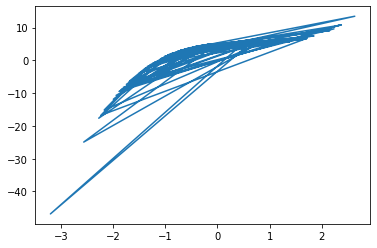

In [161]:
import  matplotlib.pyplot as plt

plt.plot(features, labels)

# complex polynomial

In [162]:
def evaluate_loss(net, data_iter, loss):
    total_loss = 0
    total_len = 0
    for X,y in data_iter:
        y_hat = net(X)
        y = y.reshape(y_hat)
        l = loss(y_hat, y)
        total_loss += l
        total_len += l.numel()
    
    return total_loss/total_len
        

In [163]:
class simpleDataset:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
        self.featres = self.features.type(torch.FloatTensor)
        self.labels = self.labels.type(torch.FloatTensor)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

train_dataset = simpleDataset(features[:n_train], labels[:n_train].reshape(-1,1))

X, y = train_dataset[0]

print(X)
print(y)
    

tensor([-1.0903])
tensor([0.4383])


In [164]:
def create_iter(features, labels, batch_size):
    return torch.utils.data.DataLoader(simpleDataset(features, labels), shuffle=True, batch_size=batch_size)

In [165]:
sample_iter = create_iter(features[:n_train], labels[:n_train], 10)

for X,y in sample_iter:
    print(X.shape, y.shape)
    break

torch.Size([10, 1]) torch.Size([10])


In [166]:
def evaluate_loss(net, data_iter, loss, text):
    total_loss = 0
    total_number = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l =  loss(y_hat, y)
            total_loss += l
            total_number += y.numel()
#     print(f"{text} loss is : {total_loss/total_number}")
    return total_loss/total_number

In [167]:

def train(train_features, train_labels, test_features, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    print(f"input feature size is : {input_shape}")
    net = nn.Sequential(nn.Linear(input_shape,1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = create_iter(train_features, train_labels.reshape(-1,1), batch_size)
    test_iter = create_iter(test_features, test_labels.reshape(-1,1), batch_size)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    # training loop
    train_loss_array = []
    test_loss_array = []
    epoch_number = []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            y_hat = net(X)
#             print(y_hat.shape)
#             print(y, y_hat)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            
            optimizer.step()
        
#         print(f"Last batch loss for epoch {epoch} is {l.detach()}")
        train_loss_array.append(evaluate_loss(net, train_iter, loss, "train"))
        test_loss_array.append(evaluate_loss(net, test_iter, loss, "test"))
        epoch_number.append(epoch)
    
    print("weight : ", net[0].weight.data.numpy())
    
    plt.plot(epoch_number[:40], train_loss_array[:40])
    plt.plot(epoch_number[:40], test_loss_array[:40])
    plt.show()

input feature size is : 4
weight :  [[ 4.9887843  1.19667   -3.3960807  5.618721 ]]


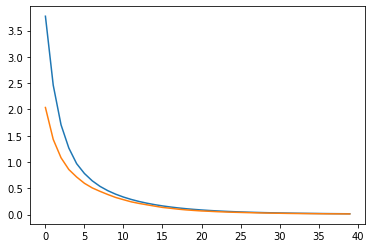

In [168]:
# fitting third order polynomial function fitting

train(poly_features[:n_train, :4], labels[:n_train], poly_features[n_train:, :4], labels[n_train:])

input feature size is : 2
weight :  [[2.5493052 5.1789804]]


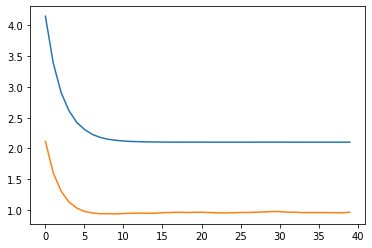

In [169]:
# now trying to underfit

train(poly_features[:n_train, :2], labels[:n_train], poly_features[n_train:, :2], labels[n_train:])

input feature size is : 20
weight :  [[ 4.942364    1.3689584  -3.2948985   5.0050473  -0.18205634  1.1978488
   0.37861416  0.00776168 -0.09995652  0.11047557  0.14559302 -0.02850519
   0.22372177 -0.09912913  0.15482725 -0.07695252 -0.20013842 -0.03450334
  -0.13877974 -0.09069248]]


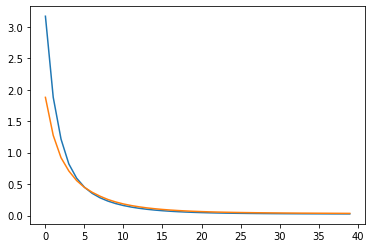

In [170]:
# trying to overfit

train(poly_features[:n_train, :],labels[:n_train], poly_features[n_train:,:], labels[n_train:])

### Exercises

1. Can you solve the polynomial regression problem exactly? Hint: use linear algebra.

dont know

2. Consider model selection for polynomials:
    1. Plot the training loss vs. model complexity (degree of the polynomial). What do you
    observe? What degree of polynomial do you need to reduce the training loss to 0?
    2. Plot the test loss in this case.
    3. Generate the same plot as a function of the amount of data.

3. What happens if you drop the normalization (1/i!) of the polynomial features x
i
? Can you
fix this in some other way?

4. Can you ever expect to see zero generalization error?

In [181]:
#2

def train_loss_vs_model_complexity(t_features, t_labels, te_features, te_labels, num_epochs=20):
    loss = nn.MSELoss()
    
    stored_train_loss = []
    
    for i in range(max_degree):
        train_features = t_features[:, :i+1]
        test_features = te_features[:, :i+1]
        train_labels = t_labels
        test_labels = te_labels
        input_shape = train_features.shape[-1]
        print(f"input feature size is : {input_shape}")
        net = nn.Sequential(nn.Linear(input_shape,1, bias=False))
        batch_size = min(10, train_labels.shape[0])
        train_iter = create_iter(train_features, train_labels.reshape(-1,1), batch_size)
        test_iter = create_iter(test_features, test_labels.reshape(-1,1), batch_size)

        optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

        # training loop
        
        for epoch in range(num_epochs):
            for X, y in train_iter:
                y_hat = net(X)
    #             print(y_hat.shape)
    #             print(y, y_hat)
                l = loss(y_hat, y)
                optimizer.zero_grad()
                l.backward()

                optimizer.step()

    #         print(f"Last batch loss for epoch {epoch} is {l.detach()}")
        stored_train_loss.append(evaluate_loss(net, train_iter, loss, "train"))
#         print("weight : ", net[0].weight.data.numpy(), "\n")
        print(f"train loss : {stored_train_loss[-1]}")
    
    plt.plot(range(max_degree), stored_train_loss)
    plt.xlabel("degree")
    plt.ylabel("loss")
    plt.show()

        
    

input feature size is : 1
train loss : 5.0660319328308105
input feature size is : 2
train loss : 2.1026580333709717
input feature size is : 3
train loss : 0.6564047932624817
input feature size is : 4
train loss : 0.09198781847953796
input feature size is : 5
train loss : 0.058192167431116104
input feature size is : 6
train loss : 0.05047869682312012
input feature size is : 7
train loss : 0.04864881560206413
input feature size is : 8
train loss : 0.05142056569457054
input feature size is : 9
train loss : 0.05376124009490013
input feature size is : 10
train loss : 0.04925350099802017
input feature size is : 11
train loss : 0.05243529751896858
input feature size is : 12
train loss : 0.05278749018907547
input feature size is : 13
train loss : 0.060016222298145294
input feature size is : 14
train loss : 0.060343556106090546
input feature size is : 15
train loss : 0.05541970580816269
input feature size is : 16
train loss : 0.05180700123310089
input feature size is : 17
train loss : 0.0565674

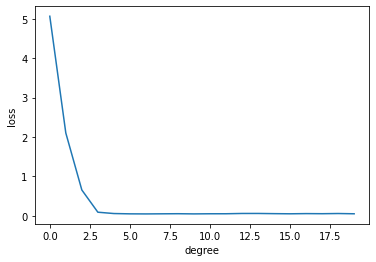

In [182]:
train_loss_vs_model_complexity(poly_features[:n_train, :],labels[:n_train], poly_features[n_train:,:], labels[n_train:])